# Corall Recommendation Engine Exploration

This notebook helps explore how the recommendation engine works by:
- Loading papers from Zotero
- Computing similarity matrices
- Analyzing citation networks
- Visualizing recommendation scores

Data is saved to `Test_Data/` directory (excluded from git).

## Setup

In [1]:
import sys
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add parent directory to path to import Corall modules
sys.path.insert(0, os.path.abspath('..'))

from src.zotero_client import ZoteroClient
from src.openalex_client import OpenAlexClient
from src.similarity_engine import SimilarityEngine
from src.citation_scorer import CitationScorer
from src.recommender import PaperRecommender
from src.journal_lists import load_journals_from_file

# Create Test_Data directory if it doesn't exist
TEST_DATA_DIR = Path('Test_Data')
TEST_DATA_DIR.mkdir(exist_ok=True)

print("✓ Imports successful")
print(f"✓ Test data directory: {TEST_DATA_DIR.absolute()}")

/Users/dkotliar/mambaforge/envs/Corall/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imports successful
✓ Test data directory: /Users/dkotliar/Desktop/Corall/Testing/Test_Data


In [12]:
from src.zotero_client import ZoteroClient
zotero_client = ZoteroClient()
collections = zotero_client.list_collections()
collections

[{'id': 'NYYT4IFF', 'name': 'Corall', 'num_items': 91, 'parent': False},
 {'id': 'GLVQ8MRP', 'name': 'RA-AIMSEQ', 'num_items': 0, 'parent': False},
 {'id': 'BNYXSK3P', 'name': 'BCAT', 'num_items': 0, 'parent': False}]

## 1. Load Papers from Zotero

In [3]:
# Initialize Zotero client for Corall library
zotero = ZoteroClient(collection_id='NYYT4IFF')

# Fetch library papers
print("Fetching papers from Zotero...")
library_papers = zotero.fetch_library()

print(f"\n✓ Loaded {len(library_papers)} papers from Zotero")
print(f"  Papers with DOI: {sum(1 for p in library_papers if p.get('doi'))}")
print(f"  Papers with abstract: {sum(1 for p in library_papers if p.get('abstract'))}")

# Save to Test_Data
with open(TEST_DATA_DIR / 'library_papers.pkl', 'wb') as f:
    pickle.dump(library_papers, f)
    
print(f"\n✓ Saved to {TEST_DATA_DIR / 'library_papers.pkl'}")

Fetching papers from Zotero...
Fetching items from collection: NYYT4IFF

✓ Loaded 91 papers from Zotero
  Papers with DOI: 0
  Papers with abstract: 91

✓ Saved to Test_Data/library_papers.pkl


In [4]:
# Display first few papers
df_papers = pd.DataFrame([{
    'title': p.get('title', '')[:60] + '...' if len(p.get('title', '')) > 60 else p.get('title', ''),
    'year': p.get('year', ''),
    'has_doi': bool(p.get('doi')),
    'has_abstract': bool(p.get('abstract')),
    'num_authors': len(p.get('authors', []))
} for p in library_papers[:10]])

print("Sample papers:")
df_papers

Sample papers:


,title,year,has_doi,has_abstract,num_authors
0,The molecular basis underlying T cell specific...,2024,False,True,9
1,Spatially organized multicellular immune hubs ...,2021,False,True,72
2,Single-cell transcriptomics of human T cells r...,2019,False,True,12
3,Single-cell transcriptomics identifies an effe...,2020,False,True,15
4,Simultaneous epitope and transcriptome measure...,2017,False,True,8
5,Pathologically expanded peripheral T helper ce...,2017,False,True,28
6,Integrated analysis of multimodal single-cell ...,2021,False,True,25
7,Identifying gene expression programs of cell-t...,2019,False,True,7
8,Functional and structural characterization of ...,2016,False,True,18
9,Diversity and clonality of T cell receptor rep...,2023,False,True,21


## 2. Compute Similarity Matrix

In [5]:
# Initialize similarity engine
similarity_engine = SimilarityEngine()

print("Building library profile (computing embeddings)...")
print("This may take a few minutes for large libraries...\n")

similarity_engine.build_library_profile(library_papers)

print(f"\n✓ Generated embeddings for {len(similarity_engine.library_embeddings)} papers")
print(f"  Embedding dimension: {similarity_engine.library_embeddings[0].shape}")

Building library profile (computing embeddings)...
This may take a few minutes for large libraries...

Loading library embeddings from cache...
Loaded embeddings for 91 papers.

✓ Generated embeddings for 91 papers
  Embedding dimension: (384,)


In [6]:
similarity_engine.library_embeddings.shape

(91, 384)

In [7]:
# Compute pairwise similarity matrix
from scipy.spatial.distance import cosine

n_papers = len(similarity_engine.library_embeddings)
similarity_matrix = np.zeros((n_papers, n_papers))

print(f"Computing {n_papers}x{n_papers} similarity matrix...")

for i in range(n_papers):
    for j in range(i, n_papers):
        if i == j:
            similarity_matrix[i, j] = 1.0
        else:
            sim = 1 - cosine(similarity_engine.library_embeddings[i], 
                           similarity_engine.library_embeddings[j])
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim
    
    if (i + 1) % 10 == 0:
        print(f"  Progress: {i+1}/{n_papers}")

print(f"\n✓ Similarity matrix computed: {similarity_matrix.shape}")

Computing 91x91 similarity matrix...
  Progress: 10/91
  Progress: 20/91
  Progress: 30/91
  Progress: 40/91
  Progress: 50/91
  Progress: 60/91
  Progress: 70/91
  Progress: 80/91
  Progress: 90/91

✓ Similarity matrix computed: (91, 91)


<Figure size 1200x1000 with 0 Axes>

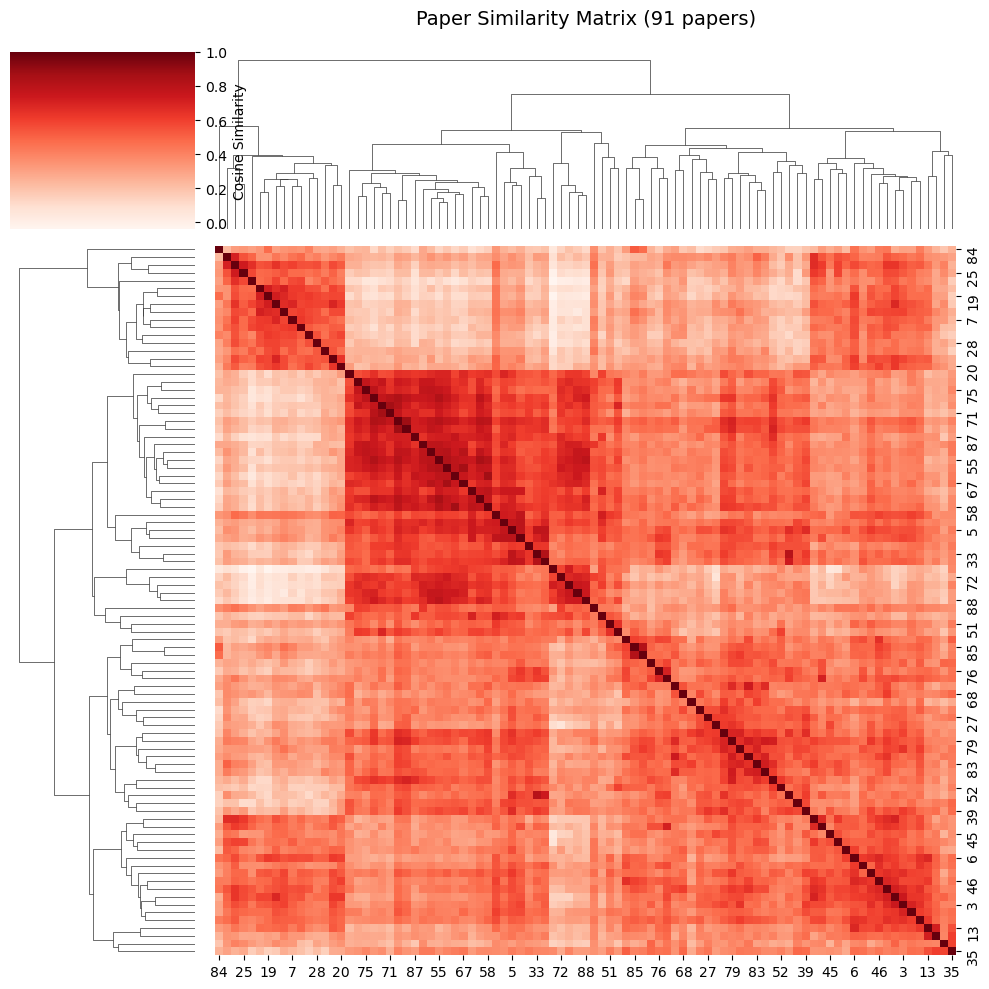

In [8]:
# Visualize similarity matrix
plt.figure(figsize=(12, 10))
res_obj = sns.clustermap(similarity_matrix, cmap='Reds',
            cbar_kws={'label': 'Cosine Similarity'})
res_obj.ax_col_dendrogram.set_title(f'Paper Similarity Matrix ({n_papers} papers)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Similarity Statistics:
  Mean similarity: 0.411
  Median similarity: 0.411
  Std deviation: 0.155
  Min similarity: -0.040
  Max similarity: 0.880
  25th percentile: 0.304
  75th percentile: 0.516


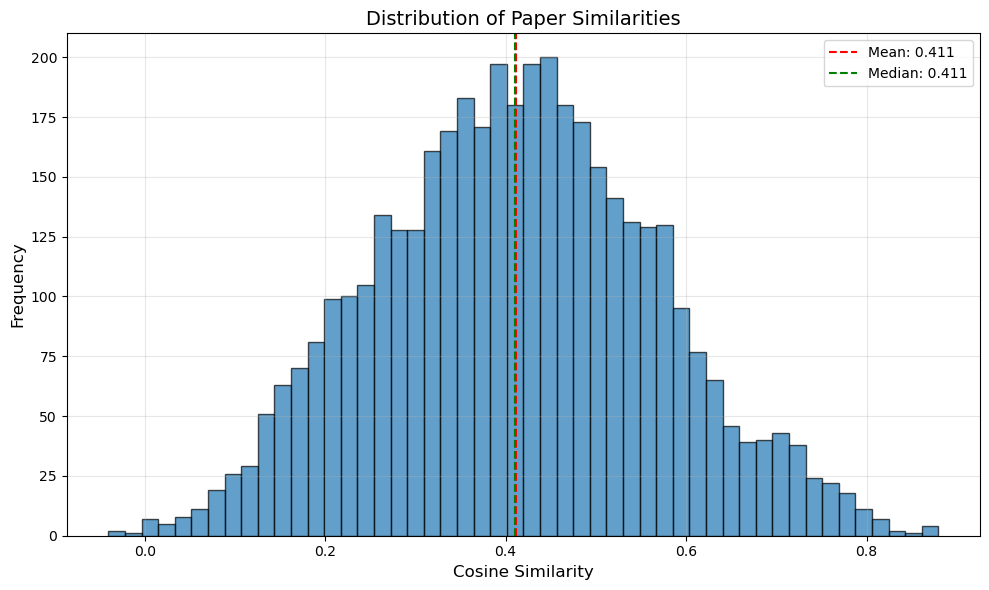

In [9]:
# Similarity statistics
# Get upper triangle (excluding diagonal)
upper_triangle = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]

print("Similarity Statistics:")
print(f"  Mean similarity: {upper_triangle.mean():.3f}")
print(f"  Median similarity: {np.median(upper_triangle):.3f}")
print(f"  Std deviation: {upper_triangle.std():.3f}")
print(f"  Min similarity: {upper_triangle.min():.3f}")
print(f"  Max similarity: {upper_triangle.max():.3f}")
print(f"  25th percentile: {np.percentile(upper_triangle, 25):.3f}")
print(f"  75th percentile: {np.percentile(upper_triangle, 75):.3f}")

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(upper_triangle, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(upper_triangle.mean(), color='red', linestyle='--', label=f'Mean: {upper_triangle.mean():.3f}')
plt.axvline(np.median(upper_triangle), color='green', linestyle='--', label=f'Median: {np.median(upper_triangle):.3f}')
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Paper Similarities', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Build Citation Network

In [10]:
# Initialize clients
openalex = OpenAlexClient()
citation_scorer = CitationScorer()

print("Building citation network from OpenAlex...")
print("This will query OpenAlex for each paper in your library.")
print("May take several minutes...\n")

citation_scorer.build_library_network(openalex, library_papers, max_citations=500, max_references=500, force_rebuild=True)

print(f"\n✓ Citation network built")
print(f"  Total works in network: {len(citation_scorer.library_network)}")
print(f"  Library papers mapped: {len([p for p in library_papers if p.get('openalex_id')])}")

# Save to Test_Data
with open(TEST_DATA_DIR / 'citation_network.pkl', 'wb') as f:
    pickle.dump(citation_scorer.library_network, f)
    
print(f"\n✓ Saved to {TEST_DATA_DIR / 'citation_network.pkl'}")

Building citation network from OpenAlex...
This will query OpenAlex for each paper in your library.
May take several minutes...

Building citation network from library...
Processing paper 1/91: The molecular basis underlying T cell specificity towards ci...
  Found in OpenAlex: W4400914168
  Added 7 citations and 57 references
Processing paper 2/91: Spatially organized multicellular immune hubs in human color...
  Found in OpenAlex: W3193419934
  Added 200 citations and 92 references
Processing paper 3/91: Single-cell transcriptomics of human T cells reveals tissue ...
  Found in OpenAlex: W2980897730
  Added 200 citations and 84 references
Processing paper 4/91: Single-cell transcriptomics identifies an effectorness gradi...
  Found in OpenAlex: W3015671642
  Added 200 citations and 78 references
Processing paper 5/91: Simultaneous epitope and transcriptome measurement in single...
  Found in OpenAlex: W2739492614
  Added 200 citations and 29 references
Processing paper 6/91: Patholog

In [11]:
# Citation network statistics
network_size = len(citation_scorer.library_network)
library_size = len(library_papers)
mapped_papers = len([p for p in library_papers if p.get('openalex_id')])

print("Citation Network Statistics:")
print(f"  Library papers: {library_size}")
print(f"  Papers mapped to OpenAlex: {mapped_papers} ({mapped_papers/library_size*100:.1f}%)")
print(f"  Total works in network: {network_size}")
print(f"  Network expansion factor: {network_size/max(mapped_papers, 1):.1f}x")

# Save statistics
stats = {
    'library_size': library_size,
    'mapped_papers': mapped_papers,
    'network_size': network_size,
    'expansion_factor': network_size/max(mapped_papers, 1)
}

with open(TEST_DATA_DIR / 'citation_stats.json', 'w') as f:
    json.dump(stats, f, indent=2)
    
print(f"\n✓ Saved statistics to {TEST_DATA_DIR / 'citation_stats.json'}")

Citation Network Statistics:
  Library papers: 91
  Papers mapped to OpenAlex: 0 (0.0%)
  Total works in network: 12423
  Network expansion factor: 12423.0x

✓ Saved statistics to Test_Data/citation_stats.json


## 4. Test Recommendation Scoring

In [12]:
from src.journal_lists import TOP_BIOLOGY_MEDICINE_JOURNALS
journal_ids = openalex.resolve_journal_ids(TOP_BIOLOGY_MEDICINE_JOURNALS)

  Matched 'Nature' -> Nature (S137773608)
  Matched 'Science' -> Science (S3880285)
  Matched 'Cell' -> Cell (S110447773)
  Matched 'The New England Journal of Medicine' -> The New England Journal of Medicine and Surgery and the Collateral Branches of Science (S4210202533)
  Matched 'The Lancet' -> The Lancet (S49861241)
  Matched 'JAMA' -> JAMA (S172573765)
  Matched 'Nature Medicine' -> Nature Medicine (S203256638)
  Matched 'Nature Biotechnology' -> Nature Biotechnology (S106963461)
  Matched 'Nature Genetics' -> Nature Genetics (S137905309)
  Matched 'Nature Immunology' -> Nature Immunology (S41063453)
  Matched 'Nature Cell Biology' -> Nature Cell Biology (S151741590)
  Matched 'Nature Structural & Molecular Biology' -> Nature Structural & Molecular Biology (S139253143)
  Matched 'Nature Microbiology' -> Nature Microbiology (S2764926557)
  Matched 'Nature Neuroscience' -> Nature Neuroscience (S2298632)
  Matched 'Nature Methods' -> Nature Methods (S127827428)
  Matched 'Nature Rev

In [13]:
# Get recent papers for testing
from datetime import datetime, timedelta

# Search for papers from last 7 days
from_date = (datetime.now() - timedelta(days=14)).strftime('%Y-%m-%d')

print(f"Searching for recent papers (from {from_date})...")
print("Note: This uses default journal filtering\n")

# Note: This may take a while depending on journal filters
# For testing, you might want to limit the number of papers
test_candidates = openalex.search_recent_papers(
    from_date=from_date,
    journal_ids=journal_ids,
    limit=5000  # Limit to 50 for faster testing
)

print(f"\n✓ Found {len(test_candidates)} candidate papers")

Searching for recent papers (from 2025-10-05)...
Note: This uses default journal filtering

  OpenAlex query: https://api.openalex.org/works
  Filters: from_publication_date:2025-10-05, primary_location.source.id:S137773608|S3880285|S110447773|S4210202533|S49861241|S172573765|S203256638|S106963461|S137905309|S41063453|S151741590|S139253143|S2764926557|S2298632|S127827428|S93373720|S8553189|S196724125|S160464432|S186543748|S64187185|S24207032|S2764653179|S2737427234|S128124174|S177533077|S25671836|S199671312|S156208185|S83804233|S169236886|S2486275289|S200071133|S114430552|S22947807|S4220651275|S1336409049|S127916151|S43092948|S81160022|S134668137|S154343897|S2764739556|S84926904|S109088427|S116900674|S2756165422|S119722071|S192814187
  Sort: publication_date:desc
  Total papers available in OpenAlex: 1207
  Fetching papers via cursor pagination (supports >10,000 results)...
  Fetched page 2 (200 papers, total: 400)
  Fetched page 3 (200 papers, total: 600)
  Fetched page 4 (200 papers,

In [15]:
# Compute scores for test candidates
print("Computing similarity scores...")
test_candidates = similarity_engine.compute_similarity(test_candidates)

print("Computing citation scores...")
test_candidates = citation_scorer.compute_advanced_citation_scores(openalex, test_candidates, max_citations=10, max_references=10)

# Compute combined scores
citation_weight = 0.3
similarity_weight = 0.7

for paper in test_candidates:
    paper['combined_score'] = (
        citation_weight * paper.get('citation_score', 0) +
        similarity_weight * paper.get('similarity_score', 0)
    )

# Sort by combined score
test_candidates.sort(key=lambda x: x['combined_score'], reverse=True)

print(f"\n✓ Scored {len(test_candidates)} papers")

# Save to Test_Data
with open(TEST_DATA_DIR / 'test_recommendations.pkl', 'wb') as f:
    pickle.dump(test_candidates, f)
    
print(f"✓ Saved to {TEST_DATA_DIR / 'test_recommendations.pkl'}")

Computing similarity scores...
Computing citation scores...
Scoring citation network for paper 1/1207...
Scoring citation network for paper 2/1207...
Scoring citation network for paper 3/1207...
Scoring citation network for paper 4/1207...
Scoring citation network for paper 5/1207...
Scoring citation network for paper 6/1207...
Scoring citation network for paper 7/1207...
Scoring citation network for paper 8/1207...
Scoring citation network for paper 9/1207...
Scoring citation network for paper 10/1207...
Scoring citation network for paper 11/1207...
Scoring citation network for paper 12/1207...
Scoring citation network for paper 13/1207...
Scoring citation network for paper 14/1207...
Scoring citation network for paper 15/1207...
Scoring citation network for paper 16/1207...
Scoring citation network for paper 17/1207...
Scoring citation network for paper 18/1207...
Scoring citation network for paper 19/1207...
Scoring citation network for paper 20/1207...
Scoring citation network for 

In [16]:
print("Computing citation scores...")
test_candidates = citation_scorer.compute_advanced_citation_scores(openalex, test_candidates, max_citations=100, max_references=100)

Computing citation scores...
Scoring citation network for paper 1/1207...
Scoring citation network for paper 2/1207...
Scoring citation network for paper 3/1207...
Scoring citation network for paper 4/1207...
Scoring citation network for paper 5/1207...
Scoring citation network for paper 6/1207...
Scoring citation network for paper 7/1207...
Scoring citation network for paper 8/1207...
Scoring citation network for paper 9/1207...
Scoring citation network for paper 10/1207...
Scoring citation network for paper 11/1207...
Scoring citation network for paper 12/1207...
Scoring citation network for paper 13/1207...
Scoring citation network for paper 14/1207...
Scoring citation network for paper 15/1207...
Scoring citation network for paper 16/1207...
Scoring citation network for paper 17/1207...
Scoring citation network for paper 18/1207...
Scoring citation network for paper 19/1207...
Scoring citation network for paper 20/1207...
Scoring citation network for paper 21/1207...
Scoring citati

In [17]:
print("Computing citation scores...")
test_candidate2 = citation_scorer.compute_advanced_citation_scores(openalex, test_candidates, max_citations=10, max_references=10)

Computing citation scores...
Scoring citation network for paper 1/1207...
Scoring citation network for paper 2/1207...
Error making request to https://api.openalex.org/works: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works?filter=cites%3AW4415308605&per_page=10 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x1bf5072b0>: Failed to resolve 'api.openalex.org' ([Errno 8] nodename nor servname provided, or not known)"))
Error making request to https://api.openalex.org/works: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works?filter=cited_by%3AW4415308605&per_page=10 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x1bf506bf0>: Failed to resolve 'api.openalex.org' ([Errno 8] nodename nor servname provided, or not known)"))
Scoring citation network for paper 3/1207...
Error making request to https://api.openalex.org/works: HTTPSConnectionPool(h

In [ ]:
# Display top recommendations
print("\nTop 10 Recommendations:\n" + "="*60)

for i, paper in enumerate(test_candidates[:10], 1):
    title = paper.get('title', 'Unknown')[:60] + '...' if len(paper.get('title', '')) > 60 else paper.get('title', 'Unknown')
    combined = paper.get('combined_score', 0)
    citation = paper.get('citation_score', 0)
    similarity = paper.get('similarity_score', 0)
    
    print(f"\n{i}. {title}")
    print(f"   Combined: {combined:.3f} | Citation: {citation:.3f} | Similarity: {similarity:.3f}")
    
    most_similar = paper.get('most_similar_paper')
    if most_similar:
        similar_title = most_similar.get('title', 'Unknown')[:50] + '...' if len(most_similar.get('title', '')) > 50 else most_similar.get('title', 'Unknown')
        print(f"   Most similar to: \"{similar_title}\"")

In [ ]:
# Visualize score distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Combined scores
combined_scores = [p.get('combined_score', 0) for p in test_candidates]
axes[0, 0].hist(combined_scores, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[0, 0].set_xlabel('Combined Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Combined Score Distribution')
axes[0, 0].axvline(np.mean(combined_scores), color='red', linestyle='--', label=f'Mean: {np.mean(combined_scores):.3f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Citation scores
citation_scores = [p.get('citation_score', 0) for p in test_candidates]
axes[0, 1].hist(citation_scores, bins=30, edgecolor='black', alpha=0.7, color='red')
axes[0, 1].set_xlabel('Citation Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Citation Score Distribution')
axes[0, 1].axvline(np.mean(citation_scores), color='darkred', linestyle='--', label=f'Mean: {np.mean(citation_scores):.3f}')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Similarity scores
similarity_scores = [p.get('similarity_score', 0) for p in test_candidates]
axes[1, 0].hist(similarity_scores, bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[1, 0].set_xlabel('Similarity Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Similarity Score Distribution')
axes[1, 0].axvline(np.mean(similarity_scores), color='darkblue', linestyle='--', label=f'Mean: {np.mean(similarity_scores):.3f}')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Scatter: Citation vs Similarity
axes[1, 1].scatter(citation_scores, similarity_scores, alpha=0.6, s=50)
axes[1, 1].set_xlabel('Citation Score')
axes[1, 1].set_ylabel('Similarity Score')
axes[1, 1].set_title('Citation vs Similarity Scores')
axes[1, 1].grid(alpha=0.3)

# Add correlation
correlation = np.corrcoef(citation_scores, similarity_scores)[0, 1]
axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
               transform=axes[1, 1].transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(TEST_DATA_DIR / 'score_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved score visualizations to {TEST_DATA_DIR / 'score_distributions.png'}")

## 5. Analyze Most Similar Papers

In [ ]:
# Count which library papers are most frequently matched
from collections import Counter

most_similar_titles = []
for paper in test_candidates:
    most_similar = paper.get('most_similar_paper')
    if most_similar:
        most_similar_titles.append(most_similar.get('title', 'Unknown'))

title_counts = Counter(most_similar_titles)

print("Top 10 Most Frequently Matched Library Papers:\n" + "="*60)
for i, (title, count) in enumerate(title_counts.most_common(10), 1):
    display_title = title[:70] + '...' if len(title) > 70 else title
    print(f"{i}. {display_title}")
    print(f"   Matched {count} times ({count/len(test_candidates)*100:.1f}% of recommendations)\n")

## 6. Summary Report

In [ ]:
# Generate summary report
summary = {
    'library': {
        'total_papers': len(library_papers),
        'papers_with_doi': sum(1 for p in library_papers if p.get('doi')),
        'papers_with_abstract': sum(1 for p in library_papers if p.get('abstract')),
    },
    'similarity': {
        'mean_similarity': float(upper_triangle.mean()),
        'median_similarity': float(np.median(upper_triangle)),
        'std_similarity': float(upper_triangle.std()),
    },
    'citation_network': {
        'network_size': len(citation_scorer.library_network),
        'mapped_papers': len([p for p in library_papers if p.get('openalex_id')]),
    },
    'recommendations': {
        'num_candidates': len(test_candidates),
        'mean_combined_score': float(np.mean(combined_scores)),
        'mean_citation_score': float(np.mean(citation_scores)),
        'mean_similarity_score': float(np.mean(similarity_scores)),
        'citation_similarity_correlation': float(correlation),
    }
}

# Save summary
with open(TEST_DATA_DIR / 'analysis_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"\nLibrary:")
print(f"  Total papers: {summary['library']['total_papers']}")
print(f"  Papers with DOI: {summary['library']['papers_with_doi']}")
print(f"  Papers with abstract: {summary['library']['papers_with_abstract']}")

print(f"\nSimilarity Matrix:")
print(f"  Mean similarity: {summary['similarity']['mean_similarity']:.3f}")
print(f"  Median similarity: {summary['similarity']['median_similarity']:.3f}")
print(f"  Std deviation: {summary['similarity']['std_similarity']:.3f}")

print(f"\nCitation Network:")
print(f"  Network size: {summary['citation_network']['network_size']} works")
print(f"  Mapped papers: {summary['citation_network']['mapped_papers']}")

print(f"\nRecommendations:")
print(f"  Candidates tested: {summary['recommendations']['num_candidates']}")
print(f"  Mean combined score: {summary['recommendations']['mean_combined_score']:.3f}")
print(f"  Mean citation score: {summary['recommendations']['mean_citation_score']:.3f}")
print(f"  Mean similarity score: {summary['recommendations']['mean_similarity_score']:.3f}")
print(f"  Citation-Similarity correlation: {summary['recommendations']['citation_similarity_correlation']:.3f}")

print(f"\n✓ Saved summary to {TEST_DATA_DIR / 'analysis_summary.json'}")
print("\n" + "="*60)

## Generated Files

All data is saved to `Test_Data/` directory:

- `library_papers.pkl` - Your Zotero library papers
- `similarity_matrix.npy` - Full similarity matrix (NxN)
- `similarity_matrix_heatmap.png` - Visualization of similarity matrix
- `similarity_distribution.png` - Distribution of similarity scores
- `citation_network.pkl` - Citation network from OpenAlex
- `citation_stats.json` - Citation network statistics
- `test_recommendations.pkl` - Test candidate papers with scores
- `score_distributions.png` - Score distribution visualizations
- `analysis_summary.json` - Complete analysis summary

**Note:** `Test_Data/` is excluded from git to save space.